<a href="https://colab.research.google.com/github/fayexu/IDL_PJ_21Spring/blob/master/Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pytorch-transformers
#use latest version of transformers instead of pytorch-transformers
!pip install transformers

     |████████████████████████████████| 2.1MB 5.2MB/s 
     |████████████████████████████████| 3.3MB 19.3MB/s 
     |████████████████████████████████| 901kB 37.2MB/s 


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM, RobertaTokenizer, RobertaForMaskedLM

# load tokenizer and pretrained model(Bert)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForMaskedLM.from_pretrained('bert-base-cased')
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# model = RobertaForMaskedLM.from_pretrained('roberta-base')
model.eval()



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [4]:
def predictMask_single(text, masked_index, k):

  tokenized_text = tokenizer.tokenize(text)
  

  # mask the text
  tokenized_text[masked_index] = '[MASK]'
  tokenized_text.insert(0,'[CLS]')
  tokenized_text.append('[SEP]')
  print("masked text: ")
  print(tokenized_text)

  # tokenizie
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  encoded_dict = tokenizer(text)

  # convert to tensor
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor(encoded_dict['token_type_ids'])

  # put on cuda
  tokens_tensor = tokens_tensor.to('cuda')
  segments_tensors = segments_tensors.to('cuda')
  model.to('cuda')

  # predict
  with torch.no_grad():
      outputs = model(tokens_tensor, token_type_ids=segments_tensors)
      predictions = outputs[0]

  # decode
  #predicted_index = torch.argmax(predictions[0, masked_index]).item()
  predicted_indexes = torch.topk(predictions[0, masked_index + 1], k)
  top_k_tokens = zip(predicted_indexes.indices.tolist(), predicted_indexes.values.tolist())
  for token, score in top_k_tokens:
    print(tokenizer.convert_ids_to_tokens([token])[0], f"(score: {score})")

In [5]:
text = "Someone winds up [MASK] right arm and knocks the fighter down with a haymaker."
mask_id = 3
topK = 10

predictMask_single(text, mask_id, topK)




masked text: 
['[CLS]', 'Someone', 'winds', 'up', '[MASK]', 'right', 'arm', 'and', 'knocks', 'the', 'fighter', 'down', 'with', 'a', 'hay', '##maker', '.', '[SEP]']
his (score: 14.178380012512207)
the (score: 12.609304428100586)
my (score: 12.085246086120605)
her (score: 11.304224014282227)
their (score: 10.660747528076172)
its (score: 10.465653419494629)
a (score: 10.252105712890625)
in (score: 9.056520462036133)
your (score: 8.616697311401367)
our (score: 8.131972312927246)


In [6]:
def predict_single_without_id(text, k):

  tokenized_text = tokenizer.tokenize(text)

  masked_index = tokenized_text.index('[MASK]')

  # mask the text
  tokenized_text[masked_index] = '[MASK]'
  tokenized_text.insert(0,'[CLS]')
  tokenized_text.append('[SEP]')
  #print("masked text: ")
  #print(tokenized_text)

  # tokenizie
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  encoded_dict = tokenizer(text)

  # convert to tensor
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor(encoded_dict['token_type_ids'])

  # put on cuda
  tokens_tensor = tokens_tensor.to('cuda')
  segments_tensors = segments_tensors.to('cuda')
  model.to('cuda')

  # predict
  with torch.no_grad():
      outputs = model(tokens_tensor, token_type_ids=segments_tensors)
      predictions = outputs[0]

  # decode
  #predicted_index = torch.argmax(predictions[0, masked_index]).item()
  predicted_indexes = torch.topk(predictions[0, masked_index + 1], k)
  top_k_tokens = zip(predicted_indexes.indices.tolist(), predicted_indexes.values.tolist())
  top_k = []
  for token, score in top_k_tokens:
    top_k.append((tokenizer.convert_ids_to_tokens([token])[0], round(score, 3)))
    #print(tokenizer.convert_ids_to_tokens([token])[0], f"(score: {score})")
  return top_k

In [7]:
line = "The belly dancer dances on stage shaking with [MASK] hips and body."
print(predict_single_without_id(line, 5))


[('her', 14.233), ('his', 13.188), ('the', 12.566), ('its', 11.525), ('both', 11.188)]


In [11]:
scores=[]

In [8]:
def get_bias_ratio(top_k):
  male_token = ["he", "his", "him", "himself", "cowboy", "cowboys", "male", "males", "father", "grandfather", "dad", "daddy" ,"son", "grandson", "man", "men", "waiter", "waiters", "gentleman", "gentlemen", "boy", "boys", "mr", "actor", "actors", "husband", "boyfriend", "brother", "brothers", "uncle", "uncles", "guy", "guys"]
  female_token = ["she", "her", "hers", "herself", "witch", "witches", "female", "females", "mother", "grandmother", "mom", "mum", "mommy", "daughter", "granddaughter", "woman", "women", "waitress", "waitresses", "lady", "ladies", "girl", "girls", "miss", "mrs", "actress", "actresses", "wife", "girlfriend", "sister", "sisters", "aunt", "aunts", "beauty"] 
  max_male_token = 'None'
  max_female_token = 'None'
  max_male_score = 0
  max_female_score = 0
  for token, score in top_k:
    if token in male_token:
      max_male_token = token
      max_male_score = score
      break
  for token, score in top_k:
    if token in female_token:
      max_female_token = token
      max_female_score = score
      break
  ratio = 0
  #if max_male_score > max_female_score:
  if max_male_token == 'None' and max_female_token == 'None':
    #print("no solution\n")
    return [0, 0];
  if max_male_score > max_female_score and max_female_score > 5:
    ratio = round(max_male_score / (max_female_score + max_male_score), 3)
    #print('Male dominates: bias score = {} with {} = {} and {} = {}\n'.format(ratio, max_male_token, max_male_score, max_female_token, max_female_score))
    print(ratio)
    scores.append(ratio)
    return [ratio, 0]
  elif max_male_score < max_female_score and max_male_score > 5:
    ratio = round(max_female_score / (max_female_score + max_male_score), 3)
    #print('Female dominates: bias score = {} with {} = {} and {} = {}\n'.format(1-ratio, max_female_token, max_female_score, max_male_token, max_male_score))
    print(1-ratio)
    scores.append(1-ratio)
    return [ratio, 1]
  return [0,0]


In [12]:
def getAverageRatio(input):
  #out = open(/content/"distribution.txt", "w")
  with open(input, 'r') as f:
    lines = f.readlines()
    male_count = 0
    max_male_ratio = 0
    sum_male_ratio = 0
    female_count = 0
    no_bias_count = 0
    max_female_ratio = 0
    sum_female_ratio = 0
    for line in lines:
      #print(line[0:-1])
      k = 10
      top_prediction = predict_single_without_id(line, k)
      ratio = get_bias_ratio(top_prediction)
      if ratio[0] != 0:
        if ratio[1] == 0:
          sum_male_ratio += ratio[0]
          male_count += 1
          if ratio[0] > max_male_ratio:
            max_male_ratio = ratio[0]
            max_male = line[0:-1]
        else:
          sum_female_ratio += ratio[0]
          female_count += 1
          if ratio[0] > max_female_ratio:
            max_female_ratio = ratio[0]
            max_female = line[0:-1]
    
    print("Total sentence: ", len(lines))
    print("Male count: ", male_count)
    print("Female count: ", female_count)
    print("Most biased to male: ", max_male, "  Ratio = ", max_male_ratio)
    print("Most biased to female: ", max_female, "  Ratio = ", 1-max_female_ratio)
    return [sum_male_ratio/male_count, sum_female_ratio/female_count]

In [13]:
male_dom, female_dom = getAverageRatio("./train_full_filtered.txt")
print("When male dominates: ", male_dom)
print("When female dominates: ", 1-female_dom)

0.519
0.564
0.628
0.507
0.523
0.522
0.58
0.564
0.564
0.585
0.543
0.543
0.546
0.504
0.514
0.532
0.518
0.543
0.577
0.521
0.552
0.555
0.547
0.556
0.537
0.6
0.495
0.526
0.551
0.563
0.536
0.541
0.531
0.564
0.52
0.502
0.544
0.549
0.552
0.506
0.539
0.594
0.521
0.563
0.496
0.48
0.505
0.563
0.55
0.583
0.552
0.485
0.574
0.508
0.511
0.58
0.586
0.547
0.585
0.548
0.582
0.531
0.527
0.511
0.43799999999999994
0.43799999999999994
0.591
0.554
0.58
0.558
0.556
0.534
0.477
0.506
0.558
0.518
0.535
0.529
0.578
0.564
0.565
0.537
0.523
0.598
0.503
0.544
0.596
0.544
0.562
0.49
0.545
0.575
0.501
0.509
0.555
0.529
0.556
0.594
0.6
0.535
0.57
0.563
0.573
0.541
0.571
0.532
0.566
0.521
0.518
0.577
0.537
0.496
0.538
0.522
0.603
0.556
0.556
0.526
0.554
0.511
0.563
0.552
0.53
0.532
0.627
0.554
0.503
0.495
0.552
0.604
0.575
0.596
0.601
0.526
0.514
0.58
0.509
0.541
0.561
0.531
0.541
0.545
0.59
0.494
0.558
0.555
0.557
0.523
0.576
0.485
0.538
0.565
0.537
0.499
0.527
0.519
0.528
0.577
0.558
0.533
0.578
0.528
0.529
0.524
0.5

[0.519, 0.564, 0.628, 0.507, 0.523, 0.522, 0.58, 0.564, 0.564, 0.585, 0.543, 0.543, 0.546, 0.504, 0.514, 0.532, 0.518, 0.543, 0.577, 0.521, 0.552, 0.555, 0.547, 0.556, 0.537, 0.6, 0.495, 0.526, 0.551, 0.563, 0.536, 0.541, 0.531, 0.564, 0.52, 0.502, 0.544, 0.549, 0.552, 0.506, 0.539, 0.594, 0.521, 0.563, 0.496, 0.48, 0.505, 0.563, 0.55, 0.583, 0.552, 0.485, 0.574, 0.508, 0.511, 0.58, 0.586, 0.547, 0.585, 0.548, 0.582, 0.531, 0.527, 0.511, 0.43799999999999994, 0.43799999999999994, 0.591, 0.554, 0.58, 0.558, 0.556, 0.534, 0.477, 0.506, 0.558, 0.518, 0.535, 0.529, 0.578, 0.564, 0.565, 0.537, 0.523, 0.598, 0.503, 0.544, 0.596, 0.544, 0.562, 0.49, 0.545, 0.575, 0.501, 0.509, 0.555, 0.529, 0.556, 0.594, 0.6, 0.535, 0.57, 0.563, 0.573, 0.541, 0.571, 0.532, 0.566, 0.521, 0.518, 0.577, 0.537, 0.496, 0.538, 0.522, 0.603, 0.556, 0.556, 0.526, 0.554, 0.511, 0.563, 0.552, 0.53, 0.532, 0.627, 0.554, 0.503, 0.495, 0.552, 0.604, 0.575, 0.596, 0.601, 0.526, 0.514, 0.58, 0.509, 0.541, 0.561, 0.531, 0.541

Text(0.5, 1.0, 'Histogram of BERT-uncased:')

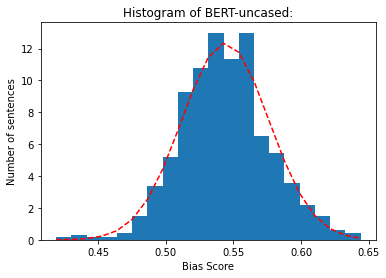

In [14]:
import numpy as np
import matplotlib.pyplot as plt
print(scores)
fig, ax = plt.subplots()
mu = np.mean(scores)
sigma = np.std(scores)
n, bins, patches = ax.hist(scores, 20, density=1)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--', color = 'red')
ax.set_xlabel('Bias Score')
ax.set_ylabel('Number of sentences')
ax.set_title('Histogram of BERT-uncased:')